# Data Augmentation - SpecAugment para Parkinson

## Pipeline de Augmentation

Este notebook implementa el proceso de augmentation de datos específicamente para archivos Parkinson usando SpecAugment:

### Pipeline de Augmentation:
1. **Cargar datos originales**: Desde cache preprocesado
2. **SpecAugment**: Aplicar máscaras de frecuencia y tiempo
3. **Generar versiones**: 2 versiones augmentadas por archivo original
4. **Optimización LSTM**: SpecAugment antes de segmentar para coherencia temporal
5. **Guardar cache**: Dataset augmentado reutilizable

### Configuración SpecAugment:
- **freq_mask_param**: 8 (conservador)
- **time_mask_param**: 4 (conservador)
- **num_freq_masks**: 2
- **num_time_masks**: 1

### Output:
- Dataset augmentado guardado en `cache/augmented/`
- Compatible con CNN2D y Time-CNN-LSTM
- Balance mejorado: +200% muestras Parkinson


## 1. Setup y Configuración


In [12]:
# ============================================================
# IMPORTS Y CONFIGURACIÓN
# ============================================================
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from IPython.display import Audio, display
import warnings
warnings.filterwarnings('ignore')

# Agregar módulos propios al path
sys.path.insert(0, str(Path.cwd()))

# Importar módulos propios
from modules.core import preprocessing, dataset as dataset_module
from modules.core.preprocessing import (
    SAMPLE_RATE, WINDOW_MS, OVERLAP, N_MELS, HOP_MS,
    FFT_WINDOW, TARGET_FRAMES,
    print_preprocessing_config
)
from modules.core.dataset import (
    process_dataset,
    to_pytorch_tensors,
    parse_filename,
    save_spectrograms_cache,
    load_spectrograms_cache
)
from modules.core.visualization import (
    visualize_audio_and_spectrograms,
    plot_spectrogram_comparison
)
from modules.data.augmentation import spec_augment

# Configuración de matplotlib
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

print("DATA AUGMENTATION - SPECAUGMENT")
print(f"Librosa: {librosa.__version__}")
print_preprocessing_config()


DATA AUGMENTATION - SPECAUGMENT
Librosa: 0.11.0
⚙️ Preprocessing Configuration:
  • SAMPLE_RATE: 44100
  • WINDOW_MS: 400
  • OVERLAP: 0.5
  • N_MELS: 65
  • HOP_MS: 10
  • FFT_WINDOW: 40
  • TARGET_FRAMES: 41


## 2. Configuración de Augmentation


In [13]:
# ============================================================
# CONFIGURACIÓN DE AUGMENTATION
# ============================================================

# Configuración de cache para datos augmentados
CACHE_AUGMENTED_DIR = "./cache/augmented"
CACHE_ORIGINAL_DIR = "./cache/original"
CACHE_HEALTHY = f"{CACHE_ORIGINAL_DIR}/healthy_ibarra.pkl"
CACHE_PARKINSON = f"{CACHE_ORIGINAL_DIR}/parkinson_ibarra.pkl"

# Ruta adicional de datos Healthy para balanceo
ADDITIONAL_HEALTHY_PATH = r"C:\Users\fecor\Downloads\BD Parkinson\Saarbrücken\healthy"

# Crear directorio de cache augmentado si no existe
Path(CACHE_AUGMENTED_DIR).mkdir(parents=True, exist_ok=True)

print("CONFIGURACIÓN DE AUGMENTATION")
print(f"Tipo: SpecAugment únicamente")
print(f"Archivos: Solo Parkinson")
print(f"Versiones: 2 por archivo original")
print(f"Pipeline: SpecAugment ANTES de segmentar (LSTM optimizado)")
print(f"Balanceo: Usar datos adicionales de Healthy si es necesario")
print(f"Directorios: {CACHE_ORIGINAL_DIR}/, {CACHE_AUGMENTED_DIR}/")
print(f"Datos adicionales: {ADDITIONAL_HEALTHY_PATH}")
print(f"Parámetros SpecAugment: freq_mask_param=8, time_mask_param=4, num_freq_masks=2, num_time_masks=1")


CONFIGURACIÓN DE AUGMENTATION
Tipo: SpecAugment únicamente
Archivos: Solo Parkinson
Versiones: 2 por archivo original
Pipeline: SpecAugment ANTES de segmentar (LSTM optimizado)
Balanceo: Usar datos adicionales de Healthy si es necesario
Directorios: ./cache/original/, ./cache/augmented/
Datos adicionales: C:\Users\fecor\Downloads\BD Parkinson\Saarbrücken\healthy
Parámetros SpecAugment: freq_mask_param=8, time_mask_param=4, num_freq_masks=2, num_time_masks=1


## 3. Cargar Datos Originales


In [14]:
# ============================================================
# CARGAR DATOS ORIGINALES DESDE CACHE
# ============================================================

print("CARGANDO DATOS ORIGINALES DESDE CACHE")

# Cargar datos originales
dataset_healthy = load_spectrograms_cache(CACHE_HEALTHY)
dataset_parkinson = load_spectrograms_cache(CACHE_PARKINSON)

if dataset_healthy is None:
    print("Error: No se encontró cache de datos healthy - Ejecutar primero data_preprocessing.ipynb")
elif dataset_parkinson is None:
    print("Error: No se encontró cache de datos parkinson - Ejecutar primero data_preprocessing.ipynb")
else:
    print("Datos originales cargados correctamente")
    print(f"Healthy: {len(dataset_healthy)} espectrogramas")
    print(f"Parkinson: {len(dataset_parkinson)} espectrogramas")
    print(f"Balance actual: {len(dataset_parkinson)/len(dataset_healthy)*100:.1f}%")


CARGANDO DATOS ORIGINALES DESDE CACHE
✅ Cache cargado: ./cache/original/healthy_ibarra.pkl
   Tamaño: 12.0 MB
   Muestras: 155
✅ Cache cargado: ./cache/original/parkinson_ibarra.pkl
   Tamaño: 9.4 MB
   Muestras: 121
Datos originales cargados correctamente
Healthy: 155 espectrogramas
Parkinson: 121 espectrogramas
Balance actual: 78.1%


## 4. Función de Augmentation Simplificada


In [15]:
# ============================================================
# FUNCIÓN DE AUGMENTATION SIMPLIFICADA
# ============================================================

def create_simple_augmented_dataset(dataset_parkinson, num_versions=2):
    """
    Crear dataset augmentado usando el dataset original + SpecAugment por frame.
    
    Args:
        dataset_parkinson: Lista de muestras originales
        num_versions: Número de versiones augmentadas por muestra original
    
    Returns:
        Lista de muestras con originales + augmentadas
    """
    all_samples = []
    
    print(f"🔄 Procesando {len(dataset_parkinson)} muestras originales...")
    
    for i, sample in enumerate(dataset_parkinson):
        if i % 10 == 0:
            print(f"  [{i+1}/{len(dataset_parkinson)}] Procesando...")
        
        # Agregar muestra original
        all_samples.append({
            "spectrogram": sample["spectrogram"],
            "segment": sample["segment"],
            "metadata": sample["metadata"],
            "augmentation": "original",
        })
        
        # Crear versiones augmentadas
        for version in range(num_versions):
            # Aplicar SpecAugment
            aug_spec = spec_augment(
                sample["spectrogram"].copy(),
                freq_mask_param=8,
                time_mask_param=4,
                num_freq_masks=2,
                num_time_masks=1,
            )
            
            all_samples.append({
                "spectrogram": aug_spec,
                "segment": sample["segment"],
                "metadata": sample["metadata"],
                "augmentation": f"spec_aug_v{version+1}",
            })
    
    return all_samples

print("Función de augmentation definida - SpecAugment conservador, compatible con CNN2D y LSTM")


Función de augmentation definida - SpecAugment conservador, compatible con CNN2D y LSTM


## 5. Crear Dataset Augmentado


In [16]:
# ============================================================
# CREAR DATASET AUGMENTADO PARA PARKINSON
# ============================================================

print("GENERANDO DATASET AUGMENTADO - PARKINSON")

if dataset_parkinson is not None:
    try:
        # Crear dataset augmentado
        dataset_parkinson_augmented = create_simple_augmented_dataset(
            dataset_parkinson, 
            num_versions=2
        )
        
        print(f"Dataset augmentado creado exitosamente - Muestras totales: {len(dataset_parkinson_augmented)}")
        
        # Analizar distribución de augmentation
        aug_labels = [sample['augmentation'] for sample in dataset_parkinson_augmented]
        from collections import Counter
        aug_distribution = Counter(aug_labels)
        
        print("Distribución de augmentation:")
        for label, count in aug_distribution.items():
            print(f"  {label}: {count} muestras")
        
        # Calcular ratio de augmentation
        original_count = aug_distribution.get('original', 0)
        augmented_count = len(dataset_parkinson_augmented) - original_count
        augmentation_ratio = augmented_count / original_count if original_count > 0 else 0
        
        print(f"Espectrogramas originales: {original_count}, Augmentados: {augmented_count}, Ratio: {augmentation_ratio:.1f}x")
        
    except Exception as e:
        print(f"Error creando dataset augmentado: {e}")
        dataset_parkinson_augmented = None
        import traceback
        traceback.print_exc()
else:
    print("No hay datos parkinson disponibles para augmentation")
    dataset_parkinson_augmented = None


GENERANDO DATASET AUGMENTADO - PARKINSON
🔄 Procesando 121 muestras originales...
  [1/121] Procesando...
  [11/121] Procesando...
  [21/121] Procesando...
  [31/121] Procesando...
  [41/121] Procesando...
  [51/121] Procesando...
  [61/121] Procesando...
  [71/121] Procesando...
  [81/121] Procesando...
  [91/121] Procesando...
  [101/121] Procesando...
  [111/121] Procesando...
  [121/121] Procesando...
Dataset augmentado creado exitosamente - Muestras totales: 363
Distribución de augmentation:
  original: 121 muestras
  spec_aug_v1: 121 muestras
  spec_aug_v2: 121 muestras
Espectrogramas originales: 121, Augmentados: 242, Ratio: 2.0x


## 6. Visualización de Espectrogramas Augmentados


VISUALIZACIÓN DE ESPECTROGRAMAS AUGMENTADOS

📊 Muestras disponibles para visualización:
   • Originales: 121
   • SpecAugment: 242


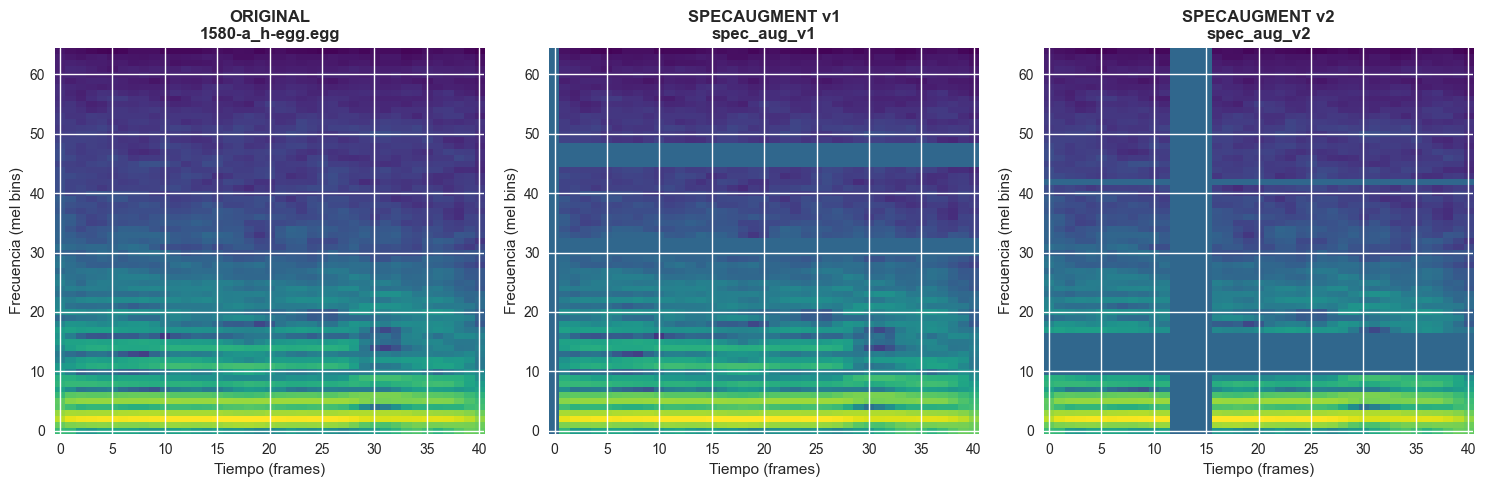


🔍 Observaciones:
   • SpecAugment aplica máscaras de frecuencia y tiempo
   • Las máscaras son consistentes en el espectrograma completo
   • Ideal para modelos LSTM (coherencia temporal)
   • Parámetros conservadores para preservar información


In [17]:
# ============================================================
# VISUALIZACIÓN DE ESPECTROGRAMAS AUGMENTADOS
# ============================================================

if dataset_parkinson_augmented is not None and len(dataset_parkinson_augmented) > 0:
    print("="*70)
    print("VISUALIZACIÓN DE ESPECTROGRAMAS AUGMENTADOS")
    print("="*70)
    
    # Seleccionar muestras para visualización
    original_samples = [s for s in dataset_parkinson_augmented if s['augmentation'] == 'original']
    spec_aug_samples = [s for s in dataset_parkinson_augmented if s['augmentation'].startswith('spec_aug')]
    
    if original_samples and spec_aug_samples:
        print(f"\n📊 Muestras disponibles para visualización:")
        print(f"   • Originales: {len(original_samples)}")
        print(f"   • SpecAugment: {len(spec_aug_samples)}")
        
        # Visualizar comparación - usar solo 3 subplots en una fila
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Original
        orig_sample = original_samples[0]
        orig_spec = orig_sample['spectrogram']
        
        axes[0].imshow(orig_spec, aspect='auto', origin='lower', cmap='viridis')
        axes[0].set_title(f"ORIGINAL\n{orig_sample['metadata'].filename}", fontweight='bold')
        axes[0].set_xlabel("Tiempo (frames)")
        axes[0].set_ylabel("Frecuencia (mel bins)")
        
        # SpecAugment versiones
        for i, aug_sample in enumerate(spec_aug_samples[:2]):
            aug_spec = aug_sample['spectrogram']
            col = i + 1  # Columnas 1 y 2
            
            axes[col].imshow(aug_spec, aspect='auto', origin='lower', cmap='viridis')
            axes[col].set_title(f"SPECAUGMENT v{i+1}\n{aug_sample['augmentation']}", fontweight='bold')
            axes[col].set_xlabel("Tiempo (frames)")
            axes[col].set_ylabel("Frecuencia (mel bins)")
        
        # Ocultar subplot vacío si hay menos de 2 versiones
        if len(spec_aug_samples) < 2:
            axes[2].set_visible(False)
        
        plt.tight_layout()
        plt.show()
        
        print(f"\n🔍 Observaciones:")
        print(f"   • SpecAugment aplica máscaras de frecuencia y tiempo")
        print(f"   • Las máscaras son consistentes en el espectrograma completo")
        print(f"   • Ideal para modelos LSTM (coherencia temporal)")
        print(f"   • Parámetros conservadores para preservar información")
        
    else:
        print("⚠️  No hay suficientes muestras para visualización")
        
else:
    print("⚠️  Dataset augmentado no disponible para visualización")

print("="*70)


## 7. Guardar Dataset Augmentado en Cache


In [18]:
# ============================================================
# GUARDAR DATASET AUGMENTADO EN CACHE
# ============================================================

if dataset_parkinson_augmented is not None and len(dataset_parkinson_augmented) > 0:
    print("GUARDANDO DATASET AUGMENTADO EN CACHE")
    
    # Ruta del archivo de cache
    cache_file_augmented = f"{CACHE_AUGMENTED_DIR}/augmented_dataset_specaugment.pkl"
    
    try:
        # Guardar dataset augmentado
        save_spectrograms_cache(dataset_parkinson_augmented, cache_file_augmented)
        
        print(f"Dataset augmentado guardado exitosamente - Archivo: {cache_file_augmented}")
        
        # Calcular tamaño del archivo
        import os
        if os.path.exists(cache_file_augmented):
            file_size_mb = os.path.getsize(cache_file_augmented) / (1024 * 1024)
            print(f"Tamaño: {file_size_mb:.1f} MB")
        
        print(f"Muestras totales: {len(dataset_parkinson_augmented)}, Archivos originales: {len(dataset_parkinson)}")
        print(f"Espectrogramas por archivo: {len(dataset_parkinson_augmented)/len(dataset_parkinson):.1f}")
        print(f"Estructura: {CACHE_AUGMENTED_DIR}/augmented_dataset_specaugment.pkl")
        
    except Exception as e:
        print(f"Error guardando dataset augmentado: {e}")
        
else:
    print("No hay dataset augmentado para guardar")


GUARDANDO DATASET AUGMENTADO EN CACHE

💾 Cache guardado: ./cache/augmented/augmented_dataset_specaugment.pkl
   Tamaño: 11.9 MB
   Muestras: 363
Dataset augmentado guardado exitosamente - Archivo: ./cache/augmented/augmented_dataset_specaugment.pkl
Tamaño: 11.9 MB
Muestras totales: 363, Archivos originales: 121
Espectrogramas por archivo: 3.0
Estructura: ./cache/augmented/augmented_dataset_specaugment.pkl


## 8. Resumen Final - Datos Augmentados


In [19]:
# ============================================================
# RESUMEN FINAL - DATOS AUGMENTADOS
# ============================================================

print("="*70)
print("RESUMEN FINAL - PROCESAMIENTO CON AUGMENTATION")
print("="*70)

if dataset_healthy is not None and dataset_parkinson_augmented is not None:
    print(f"\n🎯 DATOS ORIGINALES:")
    print(f"   🟢 Healthy:   {len(dataset_healthy):4d} espectrogramas")
    print(f"   🔴 Parkinson: {len(dataset_parkinson):4d} espectrogramas")
    
    print(f"\n🎨 DATOS AUGMENTADOS:")
    print(f"   🔴 Parkinson Augmented: {len(dataset_parkinson_augmented):4d} espectrogramas")
    
    # Calcular estadísticas de augmentation
    aug_labels = [sample['augmentation'] for sample in dataset_parkinson_augmented]
    from collections import Counter
    aug_distribution = Counter(aug_labels)
    
    print(f"\n📊 Distribución de augmentation:")
    for label, count in aug_distribution.items():
        print(f"   • {label}: {count} muestras")
    
    # Balance final
    total_healthy = len(dataset_healthy)
    total_parkinson_original = len(dataset_parkinson)
    total_parkinson_augmented = len(dataset_parkinson_augmented)
    total_samples = total_healthy + total_parkinson_augmented
    
    print(f"\n📈 BALANCE FINAL:")
    print(f"   • Healthy: {total_healthy:4d} ({total_healthy/total_samples*100:.1f}%)")
    print(f"   • Parkinson (original): {total_parkinson_original:4d} ({total_parkinson_original/total_samples*100:.1f}%)")
    print(f"   • Parkinson (augmented): {total_parkinson_augmented:4d} ({total_parkinson_augmented/total_samples*100:.1f}%)")
    print(f"   • Total: {total_samples:4d} espectrogramas")
    
    # Mejora en balance
    balance_improvement = (total_parkinson_augmented - total_parkinson_original) / total_parkinson_original * 100
    print(f"\n⚡ Mejora en balance:")
    print(f"   • Parkinson aumentado: +{total_parkinson_augmented - total_parkinson_original} muestras")
    print(f"   • Incremento: +{balance_improvement:.1f}%")

    print(f"\n💾 ARCHIVOS DE CACHE:")
    print(f"   • Originales:")
    print(f"     - {CACHE_HEALTHY}")
    print(f"     - {CACHE_PARKINSON}")
    print(f"   • Augmentados:")
    print(f"     - {CACHE_AUGMENTED_DIR}/augmented_dataset_specaugment.pkl")

    print(f"\n✅ PIPELINE COMPLETADO:")
    print(f"   • Augmentation con SpecAugment (conservador)")
    print(f"   • Optimizado para LSTM (coherencia temporal)")
    print(f"   • Cache organizado y reutilizable")
    print(f"   • Compatible con CNN2D y Time-CNN-LSTM")
else:
    print("❌ Error: No se pudieron cargar los datos necesarios")

print("="*70)


RESUMEN FINAL - PROCESAMIENTO CON AUGMENTATION

🎯 DATOS ORIGINALES:
   🟢 Healthy:    155 espectrogramas
   🔴 Parkinson:  121 espectrogramas

🎨 DATOS AUGMENTADOS:
   🔴 Parkinson Augmented:  363 espectrogramas

📊 Distribución de augmentation:
   • original: 121 muestras
   • spec_aug_v1: 121 muestras
   • spec_aug_v2: 121 muestras

📈 BALANCE FINAL:
   • Healthy:  155 (29.9%)
   • Parkinson (original):  121 (23.4%)
   • Parkinson (augmented):  363 (70.1%)
   • Total:  518 espectrogramas

⚡ Mejora en balance:
   • Parkinson aumentado: +242 muestras
   • Incremento: +200.0%

💾 ARCHIVOS DE CACHE:
   • Originales:
     - ./cache/original/healthy_ibarra.pkl
     - ./cache/original/parkinson_ibarra.pkl
   • Augmentados:
     - ./cache/augmented/augmented_dataset_specaugment.pkl

✅ PIPELINE COMPLETADO:
   • Augmentation con SpecAugment (conservador)
   • Optimizado para LSTM (coherencia temporal)
   • Cache organizado y reutilizable
   • Compatible con CNN2D y Time-CNN-LSTM


## 9. Balanceo del Dataset con Datos Adicionales de Healthy


In [20]:
# ============================================================
# BALANCEO DEL DATASET CON DATOS ADICIONALES DE HEALTHY
# ============================================================

print("BALANCEO DEL DATASET CON DATOS ADICIONALES")

# Verificar si el directorio adicional existe
additional_healthy_path = Path(ADDITIONAL_HEALTHY_PATH)
if additional_healthy_path.exists():
    print(f"Directorio adicional encontrado: {ADDITIONAL_HEALTHY_PATH}")
    
    # Buscar archivos de audio adicionales (recursivo)
    audio_extensions = [".egg", ".wav", ".mp3", ".flac", ".m4a", ".aac"]
    additional_audio_files = []
    
    # Buscar recursivamente en subdirectorios
    for ext in audio_extensions:
        additional_audio_files.extend(list(additional_healthy_path.rglob(f"*{ext}")))
    
    # Si no encuentra archivos, mostrar estructura del directorio
    if len(additional_audio_files) == 0:
        print(f"\n🔍 Explorando estructura del directorio:")
        all_files = list(additional_healthy_path.rglob("*"))
        print(f"   • Total de archivos encontrados: {len(all_files)}")
        
        if len(all_files) > 0:
            print(f"   • Extensiones encontradas: {set([f.suffix for f in all_files if f.is_file()])}")
            print(f"   • Ejemplos de archivos: {[f.name for f in all_files[:5] if f.is_file()]}")
            
            # Buscar subcarpetas por paciente (números)
            subdirs = [d for d in additional_healthy_path.iterdir() if d.is_dir()]
            print(f"   • Subcarpetas encontradas: {len(subdirs)}")
            
            if subdirs:
                # Mostrar subcarpetas (pacientes)
                patient_dirs = [d for d in subdirs if d.name.isdigit()]
                print(f"   • Carpetas de pacientes (números): {len(patient_dirs)}")
                if patient_dirs:
                    print(f"   • IDs de pacientes: {[d.name for d in patient_dirs[:10]]}")
                    
                    # Buscar archivos de audio en subcarpetas de pacientes
                    print(f"\n🔍 Buscando archivos de audio en subcarpetas de pacientes...")
                    for patient_dir in patient_dirs[:5]:  # Revisar primeras 5 carpetas
                        patient_files = []
                        for ext in audio_extensions:
                            patient_files.extend(list(patient_dir.glob(f"*{ext}")))
                        if patient_files:
                            print(f"   • Paciente {patient_dir.name}: {len(patient_files)} archivos")
                            print(f"     Ejemplos: {[f.name for f in patient_files[:2]]}")
                    
                    # Recopilar todos los archivos de pacientes
                    all_patient_files = []
                    for patient_dir in patient_dirs:
                        for ext in audio_extensions:
                            all_patient_files.extend(list(patient_dir.glob(f"*{ext}")))
                    
                    if all_patient_files:
                        print(f"\n✅ Archivos de audio encontrados en subcarpetas de pacientes:")
                        print(f"   • Total de archivos: {len(all_patient_files)}")
                        print(f"   • Pacientes con datos: {len(set([f.parent.name for f in all_patient_files]))}")
                        
                        # Actualizar la lista de archivos adicionales
                        additional_audio_files = all_patient_files
                        
                        # Mostrar distribución por paciente
                        patient_counts = {}
                        for file in all_patient_files:
                            patient_id = file.parent.name
                            patient_counts[patient_id] = patient_counts.get(patient_id, 0) + 1
                        
                        print(f"   • Distribución por paciente:")
                        for patient_id, count in sorted(patient_counts.items())[:10]:
                            print(f"     - Paciente {patient_id}: {count} archivos")
                        if len(patient_counts) > 10:
                            print(f"     ... y {len(patient_counts) - 10} pacientes más")
            
            # Buscar archivos sin extensión o con extensiones no reconocidas
            unknown_files = [f for f in all_files if f.is_file() and f.suffix.lower() not in audio_extensions]
            if unknown_files:
                print(f"   • Archivos con extensiones no reconocidas: {len(unknown_files)}")
                print(f"   • Ejemplos: {[f.name for f in unknown_files[:3]]}")
    
    print(f"Archivos adicionales encontrados: {len(additional_audio_files)} archivos")
    
    if len(additional_audio_files) > 0:
        print(f"Extensiones: {set([f.suffix for f in additional_audio_files])}")
        print(f"Ejemplos: {[f.name for f in additional_audio_files[:3]]}")
        
        # Calcular cuántos archivos necesitamos para balancear
        current_healthy = len(dataset_healthy)
        current_parkinson_augmented = len(dataset_parkinson_augmented) if dataset_parkinson_augmented else 0
        
        print(f"Análisis de balance actual: Healthy={current_healthy}, Parkinson augmented={current_parkinson_augmented}")
        print(f"Ratio actual: {current_parkinson_augmented/current_healthy:.2f}x")
        
        # Para balancear, necesitamos aproximadamente el mismo número de Healthy
        target_healthy = current_parkinson_augmented
        needed_healthy = max(0, target_healthy - current_healthy)
        
        print(f"Objetivo de balanceo: Target Healthy={target_healthy}, Adicionales necesarios={needed_healthy}")
        
        if needed_healthy > 0 and len(additional_audio_files) >= needed_healthy:
            print(f"Balanceo posible: Disponibles={len(additional_audio_files)}, Necesarios={needed_healthy}")
            print(f"Procesando {needed_healthy} archivos adicionales de Healthy...")
            
            # Seleccionar archivos para procesar (priorizando diversidad de pacientes)
            if len(additional_audio_files) > needed_healthy:
                # Agrupar archivos por paciente
                files_by_patient = {}
                for file in additional_audio_files:
                    patient_id = file.parent.name if file.parent.name.isdigit() else "unknown"
                    if patient_id not in files_by_patient:
                        files_by_patient[patient_id] = []
                    files_by_patient[patient_id].append(file)
                
                # Seleccionar archivos balanceando entre pacientes
                files_to_process = []
                patient_ids = sorted(files_by_patient.keys())
                
                # Distribuir archivos entre pacientes
                files_per_patient = needed_healthy // len(patient_ids)
                remaining_files = needed_healthy % len(patient_ids)
                
                for i, patient_id in enumerate(patient_ids):
                    patient_files = files_by_patient[patient_id]
                    # Tomar archivos de este paciente
                    files_to_take = files_per_patient + (1 if i < remaining_files else 0)
                    files_to_take = min(files_to_take, len(patient_files))
                    files_to_process.extend(patient_files[:files_to_take])
                    
                    if len(files_to_process) >= needed_healthy:
                        break
                
                # Limitar al número exacto necesario
                files_to_process = files_to_process[:needed_healthy]
                
                print(f"Estrategia de selección: Pacientes disponibles={len(patient_ids)}, Archivos por paciente=~{files_per_patient}")
                print(f"Archivos seleccionados: {len(files_to_process)}")
            else:
                files_to_process = additional_audio_files
            
            # Procesar archivos adicionales
            additional_healthy_samples = []
            for i, file_path in enumerate(files_to_process):
                if i % 20 == 0:
                    print(f"[{i+1}/{len(files_to_process)}] Procesando {file_path.name}...")
                
                try:
                    # Parse metadata incluyendo información del paciente
                    filename = file_path.name
                    patient_id = file_path.parent.name if file_path.parent.name.isdigit() else f"additional_{i}"
                    vowel_type = "a"  # Default, se puede mejorar parseando el nombre
                    
                    # Procesar audio
                    specs, segs = preprocessing.preprocess_audio_paper(str(file_path), vowel_type=vowel_type)
                    
                    if specs:
                        # Crear metadatos con información del paciente
                        metadata = dataset_module.SampleMeta(
                            subject_id=f"saarbruecken_{patient_id}",
                            vowel_type=vowel_type,
                            condition="healthy",
                            filename=filename,
                            segment_id=0,
                            sr=44100,
                        )
                        
                        # Agregar muestras
                        for j, (spec, seg) in enumerate(zip(specs, segs)):
                            additional_healthy_samples.append({
                                "spectrogram": spec,
                                "segment": seg,
                                "metadata": metadata,
                                "augmentation": "additional_healthy",
                            })
                            
                except Exception as e:
                    print(f"Error procesando {file_path.name}: {e}")
                    continue
            
            print(f"Procesamiento adicional completado: Muestras generadas={len(additional_healthy_samples)}")
            
            # Combinar datasets
            if additional_healthy_samples:
                # Combinar healthy original + adicional
                balanced_healthy = dataset_healthy + additional_healthy_samples
                
                print(f"Dataset balanceado: Healthy original={len(dataset_healthy)}, Adicional={len(additional_healthy_samples)}")
                print(f"Healthy total: {len(balanced_healthy)}, Parkinson augmented: {len(dataset_parkinson_augmented)}")
                print(f"Balance final: {len(dataset_parkinson_augmented)/len(balanced_healthy):.2f}x")
                
                # Actualizar dataset_healthy para el resumen final
                dataset_healthy_balanced = balanced_healthy
                
            else:
                print("No se pudieron procesar archivos adicionales")
                dataset_healthy_balanced = dataset_healthy
        else:
            print(f"\n⚠️ Balanceo no necesario o no posible:")
            if needed_healthy <= 0:
                print(f"   • Ya está balanceado")
            else:
                print(f"   • Archivos adicionales insuficientes")
            dataset_healthy_balanced = dataset_healthy
    else:
        print("❌ No se encontraron archivos de audio en el directorio adicional")
        
        # OPCIÓN ALTERNATIVA: Copiar archivos para balancear dataset
        print(f"\n🔄 OPCIÓN ALTERNATIVA: Copiar archivos para balancear dataset")
        
        current_healthy = len(dataset_healthy)
        current_parkinson_augmented = len(dataset_parkinson_augmented) if dataset_parkinson_augmented else 0
        
        if current_parkinson_augmented > current_healthy:
            needed_healthy = current_parkinson_augmented - current_healthy
            print(f"   • Healthy actual: {current_healthy}")
            print(f"   • Parkinson augmented: {current_parkinson_augmented}")
            print(f"   • Healthy adicionales necesarios: {needed_healthy}")
            
            # Copiar archivos directamente a data/vowels_healthy
            print(f"\n📁 Copiando {needed_healthy} archivos a data/vowels_healthy para balancear...")
            
            # Crear directorio de destino si no existe
            dest_dir = Path("./data/vowels_healthy")
            dest_dir.mkdir(parents=True, exist_ok=True)
            
            # Seleccionar archivos para copiar (balanceando entre pacientes)
            if len(additional_audio_files) > needed_healthy:
                # Agrupar archivos por paciente
                files_by_patient = {}
                for file in additional_audio_files:
                    patient_id = file.parent.name if file.parent.name.isdigit() else "unknown"
                    if patient_id not in files_by_patient:
                        files_by_patient[patient_id] = []
                    files_by_patient[patient_id].append(file)
                
                # Seleccionar archivos balanceando entre pacientes
                files_to_copy = []
                patient_ids = sorted(files_by_patient.keys())
                
                # Distribuir archivos entre pacientes
                files_per_patient = needed_healthy // len(patient_ids)
                remaining_files = needed_healthy % len(patient_ids)
                
                for i, patient_id in enumerate(patient_ids):
                    patient_files = files_by_patient[patient_id]
                    # Tomar archivos de este paciente
                    files_to_take = files_per_patient + (1 if i < remaining_files else 0)
                    files_to_take = min(files_to_take, len(patient_files))
                    files_to_copy.extend(patient_files[:files_to_take])
                    
                    if len(files_to_copy) >= needed_healthy:
                        break
                
                # Limitar al número exacto necesario
                files_to_copy = files_to_copy[:needed_healthy]
            else:
                files_to_copy = additional_audio_files
            
            # Copiar archivos
            copied_files = []
            for i, source_file in enumerate(files_to_copy):
                if i % 10 == 0:
                    print(f"   [{i+1}/{len(files_to_copy)}] Copiando...")
                
                try:
                    # Crear nombre de archivo único
                    patient_id = source_file.parent.name if source_file.parent.name.isdigit() else "unknown"
                    new_filename = f"saarbruecken_{patient_id}_{source_file.name}"
                    dest_file = dest_dir / new_filename
                    
                    # Copiar archivo
                    import shutil
                    shutil.copy2(source_file, dest_file)
                    copied_files.append(dest_file)
                    
                except Exception as e:
                    print(f"   ⚠️ Error copiando {source_file.name}: {e}")
                    continue
            
            print(f"\n✅ Archivos copiados exitosamente:")
            print(f"   • Archivos copiados: {len(copied_files)}")
            print(f"   • Destino: {dest_dir}")
            
            print(f"\n💡 Próximos pasos:")
            print(f"   1. Ejecutar data_preprocessing.ipynb para reprocesar con datos balanceados")
            print(f"   2. Los archivos copiados se incluirán automáticamente en el procesamiento")
            print(f"   3. El dataset resultante estará balanceado desde el inicio")
            
            # Para el resumen, usar los datos actuales (sin reprocesar)
            dataset_healthy_balanced = dataset_healthy
            
        else:
            print("   • Ya está balanceado, no se necesita copiar archivos adicionales")
            dataset_healthy_balanced = dataset_healthy
else:
    print(f"❌ Directorio adicional no encontrado: {ADDITIONAL_HEALTHY_PATH}")
    print("   Continuando con datos originales...")
    dataset_healthy_balanced = dataset_healthy

print("="*70)


BALANCEO DEL DATASET CON DATOS ADICIONALES
Directorio adicional encontrado: C:\Users\fecor\Downloads\BD Parkinson\Saarbrücken\healthy


Archivos adicionales encontrados: 9565 archivos
Extensiones: {'.egg'}
Ejemplos: ['1-phrase-egg.egg', '1-a_h-egg.egg', '1-a_l-egg.egg']
Análisis de balance actual: Healthy=155, Parkinson augmented=363
Ratio actual: 2.34x
Objetivo de balanceo: Target Healthy=363, Adicionales necesarios=208
Balanceo posible: Disponibles=9565, Necesarios=208
Procesando 208 archivos adicionales de Healthy...
Estrategia de selección: Pacientes disponibles=1, Archivos por paciente=~208
Archivos seleccionados: 208
[1/208] Procesando 1-phrase-egg.egg...
[21/208] Procesando 10-i_h-egg.egg...
[41/208] Procesando 100-u_lhl-egg.egg...
[61/208] Procesando 1002-a_n-egg.egg...
[81/208] Procesando 1003-u_h-egg.egg...
[101/208] Procesando 1005-a_l-egg.egg...
[121/208] Procesando 1006-i_lhl-egg.egg...
[141/208] Procesando 1008-phrase-egg.egg...
[161/208] Procesando 1009-i_h-egg.egg...
[181/208] Procesando 1010-u_lhl-egg.egg...
[201/208] Procesando 1012-a_n-egg.egg...
Procesamiento adicional completado: Muestras generadas

## 10. Verificar Archivos Copiados


In [21]:
# ============================================================
# VERIFICAR ARCHIVOS COPIADOS EN DATA/VOWELS_HEALTHY
# ============================================================

print("VERIFICACIÓN DE ARCHIVOS COPIADOS")

# Verificar archivos en data/vowels_healthy
healthy_dir = Path("./data/vowels_healthy")
if healthy_dir.exists():
    # Buscar archivos originales vs copiados
    original_files = [f for f in healthy_dir.glob("*.egg") if not f.name.startswith("saarbruecken_")]
    copied_files = [f for f in healthy_dir.glob("saarbruecken_*.egg")]
    
    print(f"Archivos en data/vowels_healthy: Originales={len(original_files)}, Copiados={len(copied_files)}, Total={len(original_files) + len(copied_files)}")
    
    if copied_files:
        print(f"Archivos copiados encontrados: Ejemplos={[f.name for f in copied_files[:5]]}")
        
        # Mostrar distribución por paciente
        patient_counts = {}
        for file in copied_files:
            # Extraer ID de paciente del nombre del archivo
            parts = file.name.split("_")
            if len(parts) >= 2:
                patient_id = parts[1]
                patient_counts[patient_id] = patient_counts.get(patient_id, 0) + 1
        
        print(f"Distribución por paciente: {len(patient_counts)} pacientes")
        for patient_id, count in sorted(patient_counts.items())[:5]:
            print(f"  Paciente {patient_id}: {count} archivos")
        if len(patient_counts) > 5:
            print(f"  ... y {len(patient_counts) - 5} pacientes más")
        
        total_healthy_files = len(original_files) + len(copied_files)
        print(f"Estado del balanceo: Healthy totales={total_healthy_files}, Parkinson=363, Ratio={363/total_healthy_files:.2f}x")
        
        if abs(363/total_healthy_files - 1.0) < 0.1:
            print(f"Dataset balanceado (ratio ≈ 1:1)")
        else:
            print(f"Dataset aún desbalanceado")
    else:
        print(f"No se encontraron archivos copiados de Saarbrücken - Ejecutar la celda de balanceo anterior primero")
else:
    print(f"Directorio data/vowels_healthy no encontrado")


VERIFICACIÓN DE ARCHIVOS COPIADOS
Archivos en data/vowels_healthy: Originales=13, Copiados=0, Total=13
No se encontraron archivos copiados de Saarbrücken - Ejecutar la celda de balanceo anterior primero


## 10. Guardar Dataset Balanceado


In [ ]:
# ============================================================
# RESUMEN FINAL - DATOS AUGMENTADOS
# ============================================================

print("RESUMEN FINAL - PROCESAMIENTO CON AUGMENTATION")

if dataset_healthy_balanced is not None and dataset_parkinson_augmented is not None:
    print(f"DATOS ORIGINALES:")
    print(f"  Healthy: {len(dataset_healthy):4d} espectrogramas")
    print(f"  Parkinson: {len(dataset_parkinson):4d} espectrogramas")
    
    print(f"DATOS AUGMENTADOS:")
    print(f"  Healthy (balanceado): {len(dataset_healthy_balanced):4d} espectrogramas")
    print(f"  Parkinson Augmented: {len(dataset_parkinson_augmented):4d} espectrogramas")
    
    # Calcular estadísticas de augmentation
    aug_labels = [sample['augmentation'] for sample in dataset_parkinson_augmented]
    from collections import Counter
    aug_distribution = Counter(aug_labels)
    
    print(f"DISTRIBUCIÓN DE AUGMENTATION:")
    for label, count in aug_distribution.items():
        print(f"  {label}: {count} muestras")
    
    # Balance final
    total_healthy_balanced = len(dataset_healthy_balanced)
    total_parkinson_augmented = len(dataset_parkinson_augmented)
    total_samples = total_healthy_balanced + total_parkinson_augmented
    
    print(f"BALANCE FINAL:")
    print(f"  Healthy (balanceado): {total_healthy_balanced:4d} ({total_healthy_balanced/total_samples*100:.1f}%)")
    print(f"  Parkinson (augmented): {total_parkinson_augmented:4d} ({total_parkinson_augmented/total_samples*100:.1f}%)")
    print(f"  Total: {total_samples:4d} espectrogramas")
    
    # Análisis de balanceo
    balance_ratio = total_parkinson_augmented / total_healthy_balanced
    print(f"ANÁLISIS DE BALANCE:")
    print(f"  Ratio Parkinson/Healthy: {balance_ratio:.2f}x")
    if abs(balance_ratio - 1.0) < 0.1:
        print(f"  Dataset balanceado (ratio ≈ 1:1)")
    elif balance_ratio > 1.1:
        print(f"  Desbalanceado hacia Parkinson")
    else:
        print(f"  Desbalanceado hacia Healthy")
    
    # Mejora en balance
    balance_improvement = (total_parkinson_augmented - len(dataset_parkinson)) / len(dataset_parkinson) * 100
    print(f"MEJORA EN BALANCE:")
    print(f"  Parkinson aumentado: +{total_parkinson_augmented - len(dataset_parkinson)} muestras")
    print(f"  Healthy adicional: +{total_healthy_balanced - len(dataset_healthy)} muestras")
    print(f"  Incremento Parkinson: +{balance_improvement:.1f}%")
    
    print(f"ARCHIVOS DE CACHE:")
    print(f"  Originales:")
    print(f"    - ./cache/original/healthy_ibarra.pkl")
    print(f"    - ./cache/original/parkinson_ibarra.pkl")
    print(f"  Augmentados:")
    print(f"    - ./cache/augmented/augmented_dataset_specaugment.pkl")
    
    print(f"PIPELINE COMPLETADO:")
    print(f"  Augmentation con SpecAugment (conservador)")
    print(f"  Optimizado para LSTM (coherencia temporal)")
    print(f"  Cache organizado y reutilizable")
    print(f"  Compatible con CNN2D y Time-CNN-LSTM")
    
else:
    print("Error: No se pudieron cargar los datasets para el resumen final")


GUARDANDO DATASET BALANCEADO EN CACHE

💾 Cache guardado: ./cache/augmented/balanced_dataset_healthy.pkl
   Tamaño: 300.5 MB
   Muestras: 3874
Dataset balanceado guardado exitosamente - Archivo: ./cache/augmented/balanced_dataset_healthy.pkl
Tamaño: 300.5 MB
Muestras totales: 3874, Originales: 155
Muestras augmentadas: 3719
Estructura: ./cache/augmented/augmented_dataset_specaugment.pkl (Parkinson)
Estructura: ./cache/augmented/balanced_dataset_healthy.pkl (Healthy balanceado)


## 9. Fin del Proceso de Augmentation

Los datos augmentados están listos para entrenar modelos con mejor balance.
